In [140]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import scipy
from scipy.optimize import curve_fit
from ast import literal_eval


import sys
#sys.path.append('/home/zelie/Python_projects/\
#water_scarcity_model/LowFlow/Code') 

from climada.hazard.low_flow import LowFlow

from climada.entity import ImpactFunc, ImpactFuncSet
from climada.entity.exposures import Exposures
from climada.engine import Impact

data_isimip_dir = '../data/hazard/'

In [124]:
fn_str_var= 'co2_dis_global_daily'
scenario = 'historical'
soc = 'histsoc'
yearrange=[1981,2005]
yearrange_ref=[1981,2005]
percentile = 10
bbox = [6, 47, 25, 54]
input_dir=data_isimip_dir
gh_model='h08'
cl_model='miroc5'
min_days_per_month=5
input_dir = data_isimip_dir

In [ ]:
haz_ho8_hadgem2 = LowFlow()
    
haz_ho8_hadgem2.set_from_nc(percentile=percentile, input_dir=input_dir, yearrange=yearrange,yearrange_ref=yearrange_ref,bbox = bbox, gh_model=gh_model,\
                    cl_model=cl_model, scenario=scenario, soc=soc, keep_dis_data = True, min_days_per_month=min_days_per_month)

In [123]:
((1-0.07)*100)/365


0.2547945205479452

In [ ]:
gh_model='matsiro'


In [ ]:
haz_matsiro_miroc5 = LowFlow()

haz_matsiro_miroc5.set_from_nc(percentile=percentile, input_dir=input_dir, yearrange=yearrange,yearrange_ref=yearrange_ref,bbox = bbox, gh_model=gh_model,\
                    cl_model=cl_model, scenario=scenario, soc=soc, keep_dis_data = True, min_days_per_month=min_days_per_month)

In [ ]:
haz_matsiro_miroc5.data['relative_dis'].mean()

In [133]:
# function to buid impact function based on days instead of relativ flow.
# IF_data is a dataframe with containing some data points to build the function:
# these must at least be a bbox for the region, a yearly flow reduction from an event in %
# and the resulting yearly loss
# The other inputs are the same as to build a hazard.



def make_IF(IF_data, min_days_per_month, percentile, input_dir, gh_model, cl_model, \
                        fn_str_var= 'co2_dis_global_daily', scenario = 'historical',
                         soc = 'histsoc', yearrange=[1981,2005], yearrange_ref=[1981,2005],):
    
    
    
    ndays_list = []

    for index in [4,5]:  # loop through impact function data points
 
        bbox = literal_eval(IF_data['bbox'].iloc[index]) # area for which to calculate the hazards

        haz = LowFlow()

        haz.set_from_nc(percentile=percentile, input_dir=input_dir, yearrange=yearrange,yearrange_ref=yearrange_ref,bbox = bbox, gh_model=gh_model,\
                    cl_model=cl_model, scenario=scenario, soc=soc, keep_dis_data = True, min_days_per_month=min_days_per_month)
   
        
        discharge_reduction = float(IF_data[''.join(['discharge_reduction_',gh_model])].iloc[index]) # yearly discharge reduction
        loss = IF_data['loss'].iloc[index]
        
        # get the number of days that the event would have to last to get the equivalent yearly flow 
        # reduction 
        ndays = discharge_reduction/(1-haz.data['relative_dis'].mean())*365
        ndays_list.append(ndays)
        
    IF_data["_".join(['ndays',gh_model,cl_model])].iloc[4:6] = ndays_list
    return(IF_data)
        

In [ ]:
fn_str_var= 'co2_dis_global_daily'
scenario = 'historical'
soc = 'histsoc'
yearrange=[1981,2005]
yearrange_ref=[1981,2005]
input_dir=data_isimip_dir
min_days_per_month=5
input_dir = data_isimip_dir
IF_data = pd.read_csv('IF_data.csv')

for gh_model in ['h08','lpjml','matsiro']:
    for cl_model in ['gfdl-esm2m','hadgem2-es','miroc5','ipsl-cm5a-lr']:
        IF_data = make_IF(IF_data, 5, 2.5, input_dir, gh_model, cl_model)

In [143]:
IF_data = pd.read_csv('IF_data.csv')


In [ ]:
IF_data = IF_data[['Focus', 'Region', 'bbox', 'discharge reduction', 'loss',
       'ndays_lpjml_gfdl-esm2m',
       'ndays_lpjml_hadgem2-es', 'ndays_lpjml_miroc5',
       'ndays_lpjml_ipsl-cm5a-lr', 'ndays_h08_gfdl-esm2m','ndays_h08_hadgem2-es', 'ndays_h08_miroc5',
       'ndays_h08_ipsl-cm5a-lr', 'ndays_matsiro_gfdl-esm2m',
       'ndays_matsiro_hadgem2-es', 'ndays_matsiro_miroc5',
       'ndays_matsiro_ipsl-cm5a-lr']]


In [ ]:
IF_data['lpjml'] = IF_data.iloc[:,5:9].mean(axis=1)

IF_data['h08'] = IF_data.iloc[:,9:13].mean(axis=1)

IF_data['matsiro'] = IF_data.iloc[:,13:17].mean(axis=1)

In [ ]:
hydro = IF_data[IF_data['Focus']=='Hydro']
thermo = IF_data[IF_data['Focus']!='Hydro']


In [152]:
IF_data.to_csv('IF_data.csv')

lpjm and h08 hydro models combined with the 4 climate models, these look like we can make a common if, the points are quite close for all combinations

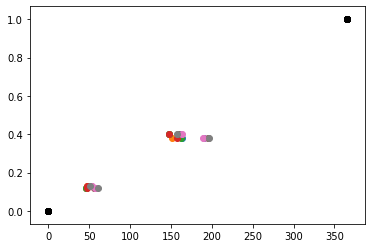

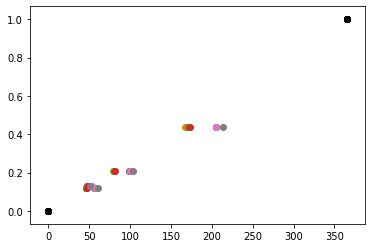

In [149]:

fig,ax = plt.subplots()
for gh_model in ['lpjml','h08']:
    for cl_model in ['gfdl-esm2m','hadgem2-es','miroc5','ipsl-cm5a-lr']:
        ax.scatter(hydro["_".join(['ndays',gh_model,cl_model])],hydro['discharge reduction'])
        ax.scatter([0,365],[0,1],color='black')                
        
fig,ax = plt.subplots()
for gh_model in ['lpjml','h08']:
    for cl_model in ['gfdl-esm2m','hadgem2-es','miroc5','ipsl-cm5a-lr']:
        ax.scatter(thermo["_".join(['ndays',gh_model,cl_model])],thermo['discharge reduction'])
        ax.scatter([0,365],[0,1],color='black')
        
 #the points in black would be assumptions       

below Matsiro hydro model, a bit of a mess... as seen above the relative discharge during events is much higher compared to the others.
I don't know if their is an error during the calculation or if it is really so.

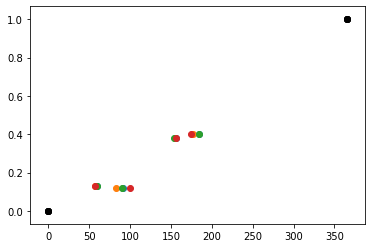

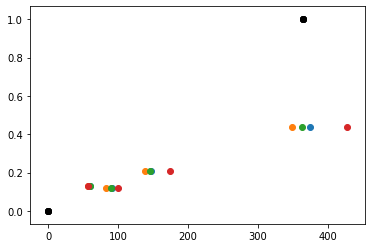

In [150]:
fig,ax = plt.subplots()
for gh_model in ['matsiro']:
    for cl_model in ['gfdl-esm2m','hadgem2-es','miroc5','ipsl-cm5a-lr']:
        ax.scatter(hydro["_".join(['ndays',gh_model,cl_model])],hydro['discharge reduction'])
        ax.scatter([0,365],[0,1], color= 'black')                
        
fig,ax = plt.subplots()
for gh_model in ['matsiro']:
    for cl_model in ['gfdl-esm2m','hadgem2-es','miroc5','ipsl-cm5a-lr']:
        ax.scatter(thermo["_".join(['ndays',gh_model,cl_model])],thermo['discharge reduction'])
        ax.scatter([0,365],[0,1],color = 'black')
        
        
        
#the points in black would be assumptions

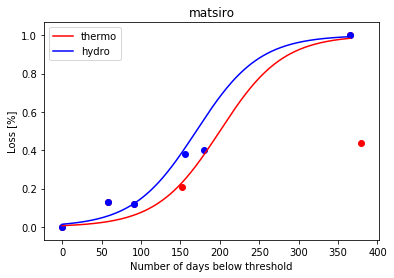

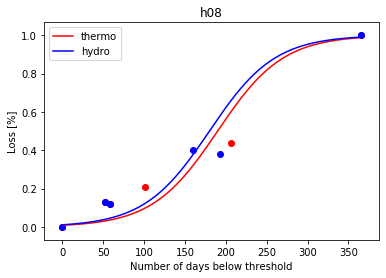

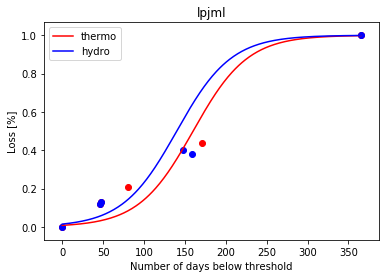

In [163]:
bounds_thermo = {'lpjml':([0.03, 120],[0.05, 160.]),'matsiro':([0.025, 160.],[0.09, 200.]),'h08':([0.025, 160.],[0.09, 190.])}
bounds_hydro = {'lpjml':([0.03, 100],[0.05, 140.]),'matsiro':([0.025, 100.],[0.09, 170.]),'h08':([0.025, 160.],[0.09, 180.])}
bounds = {'thermo':bounds_thermo,'hydro':bounds_hydro}
col = {'thermo':'Red', 'hydro':'blue'}

data = {'thermo':thermo,'hydro':hydro}

for h_model in ['matsiro','h08','lpjml']:
    fig, ax = plt.subplots()
    
    for technology in ['thermo','hydro']:
        

        n = list(data[technology][h_model])+[0,365]
        d = list(data[technology]['discharge reduction'])+[0,1]

        x0 = np.linspace(0,365,365)

        def fsigmoid(x, a, b):
            return 1.0 / (1.0 + np.exp(-a*(x-b)))

        p0 = [max(d), np.median(n), 1, min(d)]  
        popt, pcov = curve_fit(fsigmoid, n, d, method='dogbox',bounds=bounds[technology][h_model])

        fit_thermo = fsigmoid(x0,*popt)
        ax.plot(x0,fit_thermo,color = col[technology],label=technology)

        ax.scatter(n,d,color = col[technology])
        ax.set_xlabel('Number of days below threshold')
        ax.set_ylabel('Loss [%]')
        ax.legend()
        ax.set_title(" ".join([h_model]))

    
